In [115]:
import cv2
import numpy as np
import pandas as pd
import torch
import os
import time
import matplotlib.pyplot as plt
import math
import torchvision.transforms as tf
from torch.utils.data import Dataset, DataLoader
from PIL import Image


In [116]:
###Image Prep

In [128]:
###Functions 

def splitter(dataset,split=(70,15,15),seed=None):

    assert sum(split)==100

    dataset_length = len(dataset)
    
    if seed != None:
        np.random.seed(seed)
        
    train_data = []
    valid_data = []
    test_data = []
        
    for i in range(0,len(dataset)):
      
        chance = np.random.randint(0,100)

        if chance < split[0]:
            train_data.append(dataset[i,])
            
        elif chance >= split[0] and chance < (split[0]+split[1]):
            valid_data.append(dataset[i,])
        
        elif chance >= (split[0]+split[1]) and chance < sum(split): 
            test_data.append(dataset[i,])
            
        else: 
            print(chance)
  
    return np.array(train_data), np.array(valid_data), np.array(test_data)
        
    
def showRandomSamples(dataset,path='DATA/Images/destination/',seed=42):
    
    pick = np.random.randint(0,len(dataset),size=1)
    
    fig = plt.figure()
    
    #ax = fig.subplots(1,4)
    
    #for i,i_img in enumerate(pick):
        
     #   ax = fig.add_subplot(1,1,(i+1))
    img = dataset[pick]['image']
    plt.imshow(img)
    
    return none
    

In [129]:
annotations = pd.read_csv('Garth_ML_index.csv')
#annotations_good.drop(['Unusable', 'Moderately good'], axis=1, inplace=True)
quality = np.array(np.arange(0,len(annotations)))

for i in range(0,len(quality)):
    if not np.isnan(annotations['Unusable'][i]):
        quality[i]=-1.0
    elif not np.isnan(annotations['Moderately good'][i]):
        quality[i]=0.0
    elif not np.isnan(annotations['Good-number of layers'][i]):
        quality[i] = 1.0
    
annotations_class = annotations.copy()
annotations_class['quality'] = quality
print(annotations_class.head(),len(annotations))




                      File Name  Unusable  Moderately good  \
0  Garth_A01_G006_0001[0,0].jpg       1.0              NaN   
1  Garth_A01_G006_0001[0,1].jpg       1.0              NaN   
2  Garth_A01_G006_0001[0,2].jpg       1.0              NaN   
3  Garth_A01_G006_0001[0,3].jpg       1.0              NaN   
4  Garth_A01_G006_0001[0,4].jpg       1.0              NaN   

   Good-number of layers  quality  
0                    NaN       -1  
1                    NaN       -1  
2                    NaN       -1  
3                    NaN       -1  
4                    NaN       -1   16896


In [130]:
###Setup Model

In [131]:
class Model(torch.nn.Module):
    
    def __init__(self):
        
        super().__init__()

        self.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
        self.conv2 = torch.nn.Conv2d(64, 64, kernel_size=(4, 4), stride=(1, 1))
        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        self.conv4 = torch.nn.Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
        self.dropout1 = torch.nn.Dropout(p=0.10)
        self.dropout2 = torch.nn.Dropout(p=0.10)
        self.dropout3 = torch.nn.Dropout(p=0.10)
        self.dropout4 = torch.nn.Dropout(p=0.10)
        self.dropout5 = torch.nn.Dropout(p=0.10)
        self.dropout6 = torch.nn.Dropout(p=0.10)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.pool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.fc1 = torch.nn.Linear(in_features=36864, out_features=2048, bias=True)
        self.fc2 = torch.nn.Linear(in_features=2048, out_features=512, bias=True)
        self.fc3 = torch.nn.Linear(in_features=512, out_features=2, bias=True)

    def forward(self,x):
        
        x = torch.nn.ReLU(self.conv1(x))
        x = torch.nn.ReLU(self.conv2(self.dropout1(self.pool1(x))))
        x = torch.nn.ReLU(self.conv3(self.dropout2(self.pool2(x))))
        x = torch.nn.ReLU(self.conv4(self.dropout3(self.pool3(x))))
        x = torch.nn.ReLU(self.fc1(self.dropout4(self.pool4(x))))
        x = torch.nn.ReLU(self.fc2(self.dropout5(x)))
        x = self.fc3(self.dropout6(x))

        return x

In [154]:
###Custom Data Loader

class customDs(Dataset):
    
    def __init__(self,dataset,path = 'DATA/Images/destination/', transforms=None):
        
        self.dataset = dataset
        self.transforms = transforms
        self.path = path
        
        return None
    
    def __len__(self):
        return len(self.dataset)
      
    def __getitem__(self,idx):

        image = Image.open(self.path+self.dataset[idx][0])
        quality =self.dataset[idx][4]
        n_layers = self.dataset[idx][3] if not np.isnan(self.dataset[idx][3]) else 0
        
        categs = np.array([quality,n_layers])
        
        
        ##Encode for ML##
        
        if self.transforms!=None:
            image = self.transforms(image)
                        
        sample = {'image':image, 'categs':categs}

        return sample

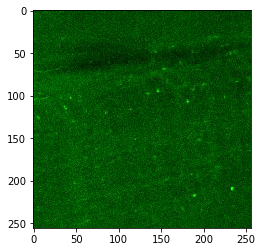

In [155]:
path = 'DATA/Images/destinations/'
img = cv2.imread('DATA/Images/destination/Garth_A01_G006_0007[0,1].jpg')
plt.imshow(img)

In [156]:
#train-valid-test split = 70%, 15%, 15%
np.random.seed(42)
ann_train, ann_valid, ann_test = splitter(annotations_class.values,(70,15,15))

print(len(ann_train))
print(len(ann_valid))
print(len(ann_test))

11821
2520
2555


In [160]:
tf_trainDs = customDs(ann_train,transforms=tf.Compose([
                                               tf.RandomHorizontalFlip(p=0.5),
                                               tf.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3, fill=0),
                                               tf.RandomRotation(degrees=20, resample=False, expand=False, center=None, fill=None),
                             #                 tf.Normalize(),
                                               tf.ToTensor()
                                           ]))

tf_validDs = customDs(ann_valid,transforms=tf.Compose([
                                               tf.RandomHorizontalFlip(p=0.5),
                                               tf.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3, fill=0),
                                               tf.RandomRotation(degrees=20, resample=False, expand=False, center=None, fill=None),
                             #                 tf.Normalize(),
                                               tf.ToTensor()
                                           ]))

tf_testDs = customDs(ann_test,transforms=tf.Compose([
                                               tf.RandomHorizontalFlip(p=0.5),
                                               tf.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3, fill=0),
                                               tf.RandomRotation(degrees=20, resample=False, expand=False, center=None, fill=None),
                             #                 tf.Normalize(),
                                               tf.ToTensor()
                                           ]))


train_loader = DataLoader(tf_trainDs, batch_size = 12, pin_memory=True, drop_last=True,shuffle=True)
valid_loader = DataLoader(tf_validDs, batch_size = 12, pin_memory=True, drop_last=True, shuffle=True)
test_loader = DataLoader(tf_testDs, batch_size = 12, pin_memory=True, drop_last=True, shuffle=True)

In [158]:
transformed_dataset[240]

{'image': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 'categs': array([1., 4.])}

In [159]:
#initiate model, loss function, optimization function

model = Model()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW( model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=True)

In [ ]:
epochs = 35
losses = []
accuracies = []



for i in epochs:
    
    for img, labels in train_loader:
    
    #Train
    
    
    #Validate
    
    
    

In [ ]:
#Backup Code

class Rescale():
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        
    def __call__(self, sample):
        
        image, categs, bndbox = sample['image'], sample['categs'], sample['bndbox']
     
        h,w = image.shape[:2]
        
        
        if isinstance(self.output_size,int):
            if h>w:
                new_h, new_w = self.output_size * h/w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size* w / h
        else:
            new_h, new_w = self.output_size
        
        new_h, new_w = int(new_h), int(new_w)
     
        image_out = transform.resize(image, (new_h, new_w))
        
        bndbox_out = bndbox.copy()
        bndbox_out[0]=int(bndbox[0]*new_w/w)
        bndbox_out[1]=int(bndbox[1]*new_h/h)
        bndbox_out[2]=int(bndbox[2]*new_w/w)
        bndbox_out[3]=int(bndbox[3]*new_h/h)
  
       
   
      
        return {'image':image_out, 'categs':categs,'bndbox':bndbox_out}
    
class RandomCrop():
    
    def __init__(self, output_size):
        assert isinstance(output_size,(int,tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size)==2
            self.output_size = output_size
            
    def __call__(self,sample):
        image, categs, bndbox = sample['image'], sample['categs'], sample['bndbox']
        
        h,w = image.shape[:2]
        
        
        new_h, new_w = self.output_size
        
     
        top = random.randint(0, h-new_h)
        left= random.randint(0, w-new_w)
        
        bndbox_out = bndbox.copy()
        bndbox_out[0]=bndbox[0]-left
        bndbox_out[1]=bndbox[1]-top
        bndbox_out[2]=bndbox[2]-left
        bndbox_out[3]=bndbox[3]-top
  

    
        image_out = image[top: top+new_h, left:left+new_w]
        

        
        return {'image':image_out,'categs':categs, 'bndbox':bndbox_out}
    
class ToTensor():
        
    def __call__(self,sample):
        image, categs, bndbox = sample['image'], sample['categs'], sample['bndbox']
            
        image = image.transpose((2,0,1))
        
                # swap color axis because
                # numpy image: H x W x C
                # torch image: C X H X W
                        
        return {'image':torch.from_numpy(image).float(),'categs':torch.from_numpy(categs).float(), 'bndbox':torch.from_numpy(bndbox).float()}


class Normalize():
    
    def __init__(self,mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]):
    
        self.mean = mean
        self.std = std
    
    def __call__(self,sample):
        
        image = sample['image']
        image_out = image.copy()
        
        for i in range(0,3):
            image_out[i] = image[i]/self.mean[i]*self.std[i]
            
            
        
        
        return {'image':image_out, 'categs':sample['categs'], 'bndbox':sample['bndbox']}